<a href="https://colab.research.google.com/github/JoGyeongDeok/Project/blob/main/Dacon/2022_05_08_A_competition_to_optimize_the_environment_for_growth3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A competition to optimize the environment for growth3
***https://dacon.io/competitions/official/235897/overview/description***

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 15 22:10:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


##1. Library % Data

In [ ]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt 
import seaborn as sns


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')      

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/DACON/Data/A competition to optimize the environment for growth'
path = "dacon_data" 
results_path = "/content/drive/MyDrive/DACON/Data/A competition to optimize the environment for growth/results"

In [ ]:
# !mkdir "{path}"
# !mkdir "{path}/weights"
# !mkdir "{path}/submission"
# !unzip "{zip_path}.zip" -d "{path}/"

In [ ]:
CFG = {
    'IMG_SIZE':360,
    'EPOCHS':40,
    'LEARNING_RATE':0.0001,
    'BATCH_SIZE':16,
    'SEED':41
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
train_df = pd.DataFrame({"img_name" : [], "leaf_weight" : [], "img_path" : [], "meta_path" : []})
data_dir = '/content/dacon_data/train'
for case_name in os.listdir(data_dir):
    current_path = os.path.join(data_dir, case_name)
    if os.path.isdir(current_path):
        label_df = pd.read_csv(current_path+'/label.csv')
        train_df = train_df.append(label_df)

train_df.reset_index(inplace = True, drop = True)

for i in range(train_df.shape[0]):
    img_name = train_df.iloc[i,0]
    meta_name = img_name[:-4] + ".csv"
    case_name = img_name[:img_name.find("_")]
    train_df.loc[i,'img_path'] = os.path.join(data_dir, case_name, "image", img_name)
    train_df.loc[i,'meta_path'] = os.path.join(data_dir, case_name, "meta", meta_name)

In [ ]:
test_df = pd.DataFrame({"img_path" : [], "meta_path" : []})

data_dir = '/content/dacon_data/test'

# get image path
img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

# get meta path
meta_list = glob(os.path.join(data_dir, 'meta', '*.csv'))

test_df.img_path = img_path_list
test_df.meta_path = meta_list

## 2. Data Precleaning

In [ ]:
cols = pd.read_csv(train_df.loc[0,'meta_path']).columns

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Train, Valid = train_test_split(train_df, test_size = 0.2, random_state = 42)

In [ ]:
len(cols)

19

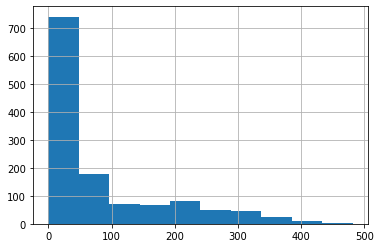

In [ ]:
Train.leaf_weight.hist()

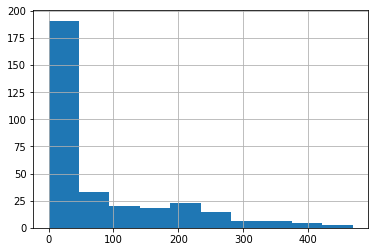

In [ ]:
Valid.leaf_weight.hist()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, train_mode = True, transforms = None, cols = None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.df = df
        self.cols = cols
    def __getitem__(self, idx):
        meta_path = list(self.df['meta_path'])[idx]
        img_path = list(self.df['img_path'])[idx]
        

        # Get meta data     NA값 변경해야함.

        # meta 특정 cols만 가져온다.
        temp_df = pd.read_csv(meta_path)[self.cols]
        temp_df = temp_df.iloc[:,1:].interpolate().fillna(method = 'bfill').mean()

        # temp_df = temp_df.iloc[:,1:].fillna(method = 'bfill', limit = 1)
        # temp_df = temp_df.iloc[:,1:].fillna(method = 'ffill', limit = 1)

        meta = torch.tensor(temp_df.values).reshape(-1)

        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = list(self.df['leaf_weight'])[idx]
            return image, meta, label
        else:
            return image, meta
            
    def __len__(self):
        return self.df.shape[0]

In [ ]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

In [ ]:
# Get Dataloader
train_dataset = CustomDataset(Train, train_mode = True, transforms = train_transform, cols= cols)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(Valid, train_mode = True, transforms = test_transform, cols= cols)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## 3. Resnet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    r"""
    3x3 convolution with padding
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        r"""
         - inplanes: input channel size
         - planes: output channel size
         - groups, base_width: ResNext나 Wide ResNet의 경우 사용
        """
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
            
        # Basic Block의 구조
        self.conv1 = conv3x3(inplanes, planes, stride)  # conv1에서 downsample
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # identity mapping시 identity mapping후 ReLU를 적용합니다.
        # 그 이유는, ReLU를 통과하면 양의 값만 남기 때문에 Residual의 의미가 제대로 유지되지 않기 때문입니다.
        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups
        
        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class MetaBlock(nn.Module):
    """
    Implementing the Metadata Processing Block (MetaBlock)
    """
    def __init__(self, V, U):
        super(MetaBlock, self).__init__()
        self.fb = nn.Sequential(nn.Linear(U, V), nn.BatchNorm1d(V))
        self.gb = nn.Sequential(nn.Linear(U, V), nn.BatchNorm1d(V))

    def forward(self, V, U):
        t1 = self.fb(U)
        t2 = self.gb(U)
        V = torch.sigmoid(torch.tanh(V * t1.unsqueeze(-1)) + t2.unsqueeze(-1))
        return V

In [ ]:
'''
block과 layers는 resnet 종류에 따라 달라짐
'''

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes = 1, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # default values
        self.inplanes = 64 # input feature map
        self.dilation = 1
        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일 
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3
        """
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.Linear1 = nn.Linear(17, 64)     #featuremap의 개수

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트
        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, image, meta):
        # See note [TorchScript super()]
        x1 = self.conv1(image)

        # # attention
        x2 = self.Linear1(meta)     #feature map 크기로 신경망 통과.
        x2 = F.relu(x2)

        x3 = self.Linear1(meta)     #feature map 크기로 신경망 통과
        x3 = F.relu(x3)
        print(x3)
        # element-wise product를 위해 reshape
        x1 = x1.reshape(x1.shape[3], x1.shape[2], x1.shape[1], x1.shape[0])
        x2 = x2.reshape(x2.shape[1], x2.shape[0])
        x3 = x3.reshape(x3.shape[1], x3.shape[0])

        print("x1 : " , x1)
        print("x2 : " , x2)
        print("x3 : " , x3)
        print("------------------------")
        

        # x1이 0에 가까워짐 =>  F.tanh(0) = 0, F.sigmoid(0) = 0.5
        x1 = F.sigmoid(F.tanh(x2 * x1) + x3)    #(batch_size, feature maps, img_m, img_n) 크기로 반환      
                            

        # 원래대로 돌리기
        x1 = x1.reshape(x1.shape[3], x1.shape[2], x1.shape[1], x1.shape[0])

        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.maxpool(x1)

        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = self.layer3(x1)
        x1 = self.layer4(x1)

        x1 = self.avgpool(x1)

        x1 = torch.flatten(x1, 1)
        x1 = self.fc(x1)


        # # Meta Model
        # x2 = self.Metalayer1(meta)
        # x2 = self.batch_norm1(x2)
        # x2 = F.relu(x2)
        # x2 = F.dropout(x2, training = self.training, p = self.dropout_prob)

        # x2 = self.Metalayer2(x2)
        # x2 = self.batch_norm2(x2)
        # x2 = F.relu(x2)
        # x2 = F.dropout(x2, training = self.training, p = self.dropout_prob)


        # # Concat
        # x = torch.cat((x1, x2), dim = 1)
        
        # # Regressor
        # x = self.Concatlayer(x)
        # x = self.batch_norm2(x)
        # x = F.relu(x)
        # x = F.dropout(x, training = self.training, p = self.dropout_prob)
        # x = self.regressorlayer(x)

        return x1

    def forward(self, image, meta):
        return self._forward_impl(image, meta)

In [ ]:
x1 = torch.tensor(range(16*64*128*128)).reshape(16, 64, 128, 128)
x2 = torch.tensor(range(16*64)).reshape(16, 64)
x3 = torch.tensor(range(16*64)).reshape(16, 64)

In [ ]:
x1 = x1.reshape(x1.shape[3], x1.shape[2], x1.shape[1], x1.shape[0])      
x2 = x2.reshape(x2.shape[1], x2.shape[0])        
x3 = x3.reshape(x3.shape[1], x3.shape[0])        
print(x1.shape)
print(x2.shape)
print(x3.shape)

torch.Size([128, 128, 64, 16])
torch.Size([64, 16])
torch.Size([64, 16])


In [ ]:
x1 = F.sigmoid(F.tanh(x2 * x1) + x3)
print(x1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([128, 128, 64, 16])


In [ ]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

In [ ]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

In [ ]:
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

## 4. EfficientnetV2

In [ ]:
"""
Creates a EfficientNetV2 Model as defined in:
Mingxing Tan, Quoc V. Le. (2021). 
EfficientNetV2: Smaller Models and Faster Training
arXiv preprint arXiv:2104.00298.
import from https://github.com/d-li14/mobilenetv2.pytorch
"""

import torch
import torch.nn as nn
import math

__all__ = ['effnetv2_s', 'effnetv2_m', 'effnetv2_l', 'effnetv2_xl']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# SiLU (Swish) activation function
if hasattr(nn, 'SiLU'):
    SiLU = nn.SiLU
else:
    # For compatibility with old PyTorch versions
    class SiLU(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)

 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [ ]:
class EffNetV2(nn.Module):
    def __init__(self, cfgs, num_classes=1, width_mult=1.):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


        #attention
        self.Linear1 = nn.Linear(5, output_channel)

        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, img, meta):
        x1 = self.features(img)
        x1 = self.conv(x1)
        x1 = self.avgpool(x1)
        x1 = x1.view(x1.size(0), -1)

        # attention
        # x2 = self.Linear1(meta)
        # x3 = self.Linear1(meta)
        # x1 = F.sigmoid(F.tanh(x2 * x1) + x3)


        x1 = self.classifier(x1)
        return x1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()

In [ ]:
def effnetv2_s(**kwargs):
    """
    Constructs a EfficientNetV2-S model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  2, 1, 0],
        [4,  48,  4, 2, 0],
        [4,  64,  4, 2, 0],
        [4, 128,  6, 2, 1],
        [6, 160,  9, 1, 1],
        [6, 256, 15, 2, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_m(**kwargs):
    """
    Constructs a EfficientNetV2-M model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  3, 1, 0],
        [4,  48,  5, 2, 0],
        [4,  80,  5, 2, 0],
        [4, 160,  7, 2, 1],
        [6, 176, 14, 1, 1],
        [6, 304, 18, 2, 1],
        [6, 512,  5, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_l(**kwargs):
    """
    Constructs a EfficientNetV2-L model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  7, 2, 0],
        [4,  96,  7, 2, 0],
        [4, 192, 10, 2, 1],
        [6, 224, 19, 1, 1],
        [6, 384, 25, 2, 1],
        [6, 640,  7, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_xl(**kwargs):
    """
    Constructs a EfficientNetV2-XL model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  8, 2, 0],
        [4,  96,  8, 2, 0],
        [4, 192, 16, 2, 1],
        [6, 256, 24, 1, 1],
        [6, 512, 32, 2, 1],
        [6, 640,  8, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)

## 5. 실험

In [ ]:
from torchvision import models

In [ ]:
class MetaBlock(nn.Module):
    """
    Implementing the Metadata Processing Block (MetaBlock)
    """
    def __init__(self, V, U):
        super(MetaBlock, self).__init__()
        self.fb = nn.Sequential(nn.Linear(U, V), nn.BatchNorm1d(V))
        self.gb = nn.Sequential(nn.Linear(U, V), nn.BatchNorm1d(V))

    def forward(self, V, U):
        t1 = self.fb(U)
        t2 = self.gb(U)
        V = torch.sigmoid(torch.tanh(V * t1.unsqueeze(-1)) + t2.unsqueeze(-1))
        return V

In [ ]:
class MyEffnet (nn.Module):

    def __init__(self, efnet, num_class, neurons_reducer_block=256, p_dropout=0.5,
                 comb_method=None, comb_config=None, n_feat_conv=1792):

        super(MyEffnet, self).__init__()

        _n_meta_data = 0
        if comb_method is not None:
            if comb_config is None:
                raise Exception("You must define the comb_config since you have comb_method not None")

            if comb_method == 'metablock':
                if isinstance(comb_config, int):
                    self.comb_feat_maps = 32
                    self.comb = MetaBlock(self.comb_feat_maps, comb_config)
                elif isinstance(comb_config, list):
                    self.comb = MetaBlock(self.comb_feat_maps, comb_config[1])
                    self.comb_feat_maps = comb_config[0]
                else:
                    raise Exception(
                        "comb_config must be a list or int to define the number of feat maps and the metadata")
            elif comb_method == 'concat':
                if not isinstance(comb_config, int):
                    raise Exception("comb_config must be int for 'concat' method")
                _n_meta_data = comb_config
                self.comb = 'concat'
            elif comb_method == 'metanet':
                if isinstance(comb_config, int):
                    self.comb_feat_maps = 28
                    self.comb = MetaNet(comb_config, 64, 28)
                elif isinstance(comb_config, list):
                    self.comb = MetaNet(comb_config[0], comb_config[1], comb_config[2])
                    self.comb_feat_maps = comb_config[2]
                else:
                    raise Exception(
                        "comb_config must be a list or int to define the number of feat maps and the metadata")
            else:
                raise Exception("There is no comb_method called " + comb_method + ". Please, check this out.")
        else:
            self.comb = None

        self.efnet = efnet
        self.avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Feature reducer
        if neurons_reducer_block > 0:
            self.reducer_block = nn.Sequential(
                nn.Linear(n_feat_conv, neurons_reducer_block),
                nn.BatchNorm1d(neurons_reducer_block),
                nn.ReLU(),
                nn.Dropout(p=p_dropout)
            )
        else:
            if comb_method == 'concat':
                warnings.warn("You're using concat with neurons_reducer_block=0. Make sure you're doing it right!")
            self.reducer_block = None

        # Here comes the extra information (if applicable)
        if neurons_reducer_block > 0:
            self.classifier = nn.Linear(neurons_reducer_block + _n_meta_data, num_class)
        else:
            self.classifier = nn.Linear(n_feat_conv + _n_meta_data, num_class)


    def forward(self, img, meta_data=None):

        # Checking if when passing the metadata, the combination method is set
        if meta_data is not None and self.comb is None:
            raise Exception("There is no combination method defined but you passed the metadata to the model!")
        if meta_data is None and self.comb is not None:
            raise Exception("You must pass meta_data since you're using a combination method!")

        x = self.efnet.features(img)
        x = self.avg_pooling(x)

        if self.comb == None:
            x = x.view(x.size(0), -1)  # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x)  # feat reducer block
        elif self.comb == 'concat':
            x = x.view(x.size(0), -1)  # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x)  # feat reducer block. In this case, it must be defined
            x = torch.cat([x, meta_data], dim=1)  # concatenation
        elif isinstance(self.comb, MetaBlock):
            x = x.view(x.size(0), self.comb_feat_maps, 32, -1).squeeze(-1)  # getting the feature maps
            x = self.comb(x, meta_data.float())  # applying metablock
            x = x.view(x.size(0), -1)  # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x)  # feat reducer block
        elif isinstance(self.comb, MetaNet):
            x = x.view(x.size(0), self.comb_feat_maps, 8, 8).squeeze(-1)  # getting the feature maps
            x = self.comb(x, meta_data.float())  # applying metanet
            x = x.view(x.size(0), -1)  # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x)  # feat reducer block

        return self.classifier(x)

In [ ]:
import warnings
class MyResnet (nn.Module):

    def __init__(self, resnet, num_class, neurons_reducer_block=256, freeze_conv=False, p_dropout=0.5,
                 comb_method=None, comb_config=None, n_feat_conv=2048):

        super(MyResnet, self).__init__()

        _n_meta_data = 0
        if comb_method is not None:
            if comb_config is None:
                raise Exception("You must define the comb_config since you have comb_method not None")

            if comb_method == 'metablock':
                if isinstance(comb_config, int):
                    self.comb_feat_maps = 64
                    self.comb = MetaBlock(self.comb_feat_maps, comb_config)
                elif isinstance(comb_config, list):
                    self.comb = MetaBlock(self.comb_feat_maps, comb_config[1])
                    self.comb_feat_maps = comb_config[0]
                else:
                    raise Exception(
                        "comb_config must be a list or int to define the number of feat maps and the metadata")
            elif comb_method == 'concat':
                if not isinstance(comb_config, int):
                    raise Exception("comb_config must be int for 'concat' method")
                _n_meta_data = comb_config
                self.comb = 'concat'

        else:
            self.comb = None

        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # freezing the convolution layers
        if freeze_conv:
            for param in self.features.parameters():
                param.requires_grad = False

        # Feature reducer
        if neurons_reducer_block > 0:
            self.reducer_block = nn.Sequential(
                nn.Linear(n_feat_conv, neurons_reducer_block),
                nn.BatchNorm1d(neurons_reducer_block),
                nn.ReLU(),
                nn.Dropout(p=p_dropout)
            )
        else:
            if comb_method == 'concat':
                warnings.warn("You're using concat with neurons_reducer_block=0. Make sure you're doing it right!")
            self.reducer_block = None

        # Here comes the extra information (if applicable)
        if neurons_reducer_block > 0:
            self.classifier = nn.Linear(neurons_reducer_block + _n_meta_data, num_class)
        else:
            self.classifier = nn.Linear(n_feat_conv + _n_meta_data, num_class)


    def forward(self, img, meta_data=None):

        # Checking if when passing the metadata, the combination method is set
        if meta_data is not None and self.comb is None:
            raise Exception("There is no combination method defined but you passed the metadata to the model!")
        if meta_data is None and self.comb is not None:
            raise Exception("You must pass meta_data since you're using a combination method!")

        x = self.features(img)

        if self.comb == None:
            x = x.view(x.size(0), -1) # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x)  # feat reducer block
        elif self.comb == 'concat':
            x = x.view(x.size(0), -1) # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x) # feat reducer block. In this case, it must be defined
            x = torch.cat([x, meta_data], dim=1) # concatenation
            
        elif isinstance(self.comb, MetaBlock):
            x = x.view(x.size(0), self.comb_feat_maps, 32, -1).squeeze(-1) # getting the feature maps
            x = self.comb(x, meta_data.float()) # applying metablock
            x = x.view(x.size(0), -1) # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x)  # feat reducer block
        elif isinstance(self.comb, MetaNet):
            x = x.view(x.size(0), self.comb_feat_maps, 8, 8).squeeze(-1)  # getting the feature maps
            x = self.comb(x, meta_data.float())  # applying metanet
            x = x.view(x.size(0), -1)  # flatting
            if self.reducer_block is not None:
                x = self.reducer_block(x)  # feat reducer block
                

        return self.classifier(x)

In [ ]:
_MODELS = ['resnet-50', 'resnet-101', 'densenet-121', 'vgg-13', 'vgg-16', 'vgg-19',
           'mobilenet', 'efficientnet-b4']

_NORM_AND_SIZE = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225], [224, 224]]

## 6. 학습

In [ ]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, meta, label in tqdm(iter(train_loader)):
            img, meta, label = img.float().to(device), meta.float().to(device),label.float().to(device)
            optimizer.zero_grad()
            # Data -> Model -> Output
            logit = model(img)
            logit = logit.squeeze(1)
            # logit = (483-0) * logit + 0       # sigmoid 함수 사용했을 때
            # Calc loss
            loss = criterion(logit, label)
            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), '/content/dacon_data/weights/best_model.pth')
            print('Model Saved.')

In [ ]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        for img, meta, label in tqdm(iter(vali_loader)):
            img, meta, label = img.float().to(device), meta.float().to(device), label.float().to(device)

            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# model = resnext101_32x8d(pretrained = False)

# comb_config = metadata 개수
model = MyResnet(models.resnext101_32x8d(pretrained=True), num_class = 1, neurons_reducer_block = 0, freeze_conv = False)

# model = MyEffnet(effnetv2_l(), num_class = 1, neurons_reducer_block = 256,
#                          comb_method='metablock', comb_config=17)

optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

train(model, optimizer, train_loader, vali_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1] Train MAE : [78.59627] Validation MAE : [78.66801]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2] Train MAE : [76.61212] Validation MAE : [76.36406]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3] Train MAE : [74.24780] Validation MAE : [73.54681]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4] Train MAE : [70.95176] Validation MAE : [70.23707]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5] Train MAE : [67.75925] Validation MAE : [66.50406]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6] Train MAE : [64.02892] Validation MAE : [62.63974]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7] Train MAE : [60.33932] Validation MAE : [57.90696]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8] Train MAE : [56.96533] Validation MAE : [56.40057]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9] Train MAE : [53.25565] Validation MAE : [51.49773]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10] Train MAE : [49.44970] Validation MAE : [46.07987]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11] Train MAE : [45.91477] Validation MAE : [41.59235]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12] Train MAE : [42.61501] Validation MAE : [43.60823]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13] Train MAE : [38.58559] Validation MAE : [35.85986]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14] Train MAE : [34.48285] Validation MAE : [34.20514]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15] Train MAE : [31.14165] Validation MAE : [24.26771]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16] Train MAE : [28.57990] Validation MAE : [26.38897]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17] Train MAE : [26.72065] Validation MAE : [25.85195]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18] Train MAE : [23.74737] Validation MAE : [18.35920]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19] Train MAE : [21.77366] Validation MAE : [18.29141]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20] Train MAE : [20.88127] Validation MAE : [11.81660]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21] Train MAE : [18.36381] Validation MAE : [12.30455]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22] Train MAE : [19.33629] Validation MAE : [21.08453]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23] Train MAE : [18.39639] Validation MAE : [13.56055]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24] Train MAE : [14.97437] Validation MAE : [17.65593]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25] Train MAE : [14.89702] Validation MAE : [6.23046]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26] Train MAE : [13.78335] Validation MAE : [15.20217]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27] Train MAE : [12.83609] Validation MAE : [9.92989]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28] Train MAE : [12.34185] Validation MAE : [34.44356]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29] Train MAE : [13.00019] Validation MAE : [9.33449]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30] Train MAE : [10.92110] Validation MAE : [6.40494]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31] Train MAE : [11.90407] Validation MAE : [8.30467]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32] Train MAE : [9.37590] Validation MAE : [7.53788]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33] Train MAE : [11.50060] Validation MAE : [12.70577]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34] Train MAE : [10.03430] Validation MAE : [6.09425]

Model Saved.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35] Train MAE : [8.23838] Validation MAE : [10.96987]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36] Train MAE : [8.85326] Validation MAE : [9.98976]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37] Train MAE : [8.60775] Validation MAE : [6.25237]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38] Train MAE : [8.16395] Validation MAE : [8.80546]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39] Train MAE : [10.23441] Validation MAE : [7.64562]



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40] Train MAE : [9.78250] Validation MAE : [8.33740]



In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():

        for img, meta in tqdm(iter(test_loader)):
            img, meta = img.float().to(device), meta.float().to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_df, train_mode = False, transforms=test_transform, cols = cols)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Score가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/dacon_data/weights/best_model.pth')
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)

  0%|          | 0/29 [00:00<?, ?it/s]

## 7. 예측

In [ ]:
submission = pd.read_csv('/content/dacon_data/sample_submission.csv')
submission['leaf_weight'] =  preds
submission.to_csv('/content/drive/MyDrive/DACON/Data/A competition to optimize the environment for growth/submission/실험.csv', index=False)